[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/franckalbinet/mirzai/blob/main/nbs/08_paper.plsr.learning_curve.ipynb)

# 3.1. Learning Curve (PLSR)

> Computing the learning curve of PLSR for the prediction of exchangeable potassium (K ex.), with increasing number of training examples and using all Soil Taxonomy Orders. 

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=False)
    !pip install mirzai
else:
    %load_ext autoreload
    %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pickle

# mirzai utilities
from mirzai.data.loading import load_kssl
from mirzai.data.selection import (select_y, select_tax_order, select_X)
from mirzai.data.transform import (log_transform_y, SNV, TakeDerivative,
                                   DropSpectralRegions, CO2_REGION)

from mirzai.training.plsr import Learner
from mirzai.training.core import load_dumps
from fastcore.transform import compose

# Python utilities
from collections import OrderedDict
from tqdm.auto import tqdm
from pathlib import Path

# Data science stack
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Load and transform

In [ ]:
src_dir = 'data' # Replace by the path your downloaded the data to
fnames = ['spectra-features.npy', 'spectra-wavenumbers.npy', 
          'depth-order.npy', 'target.npy', 
          'tax-order-lu.pkl', 'spectra-id.npy']

X, X_names, depth_order, y, tax_lookup, X_id = load_kssl(src_dir, fnames=fnames)

data = X, y, X_id, depth_order

transforms = [select_y, select_tax_order, select_X, log_transform_y]
X, y, X_id, depth_order = compose(*transforms)(data)

In [ ]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'Wavenumbers:\n {X_names}')
print(f'depth_order (first 3 rows):\n {depth_order[:3, :]}')
print(f'Taxonomic order lookup:\n {tax_lookup}')

X shape: (40132, 1764)
y shape: (40132,)
Wavenumbers:
 [3999 3997 3995 ...  603  601  599]
depth_order (first 3 rows):
 [[43.  2.]
 [ 0.  0.]
 [ 0.  1.]]
Taxonomic order lookup:
 {'alfisols': 0, 'mollisols': 1, 'inceptisols': 2, 'entisols': 3, 'spodosols': 4, 'undefined': 5, 'ultisols': 6, 'andisols': 7, 'histosols': 8, 'oxisols': 9, 'vertisols': 10, 'aridisols': 11, 'gelisols': 12}


## Setup

In [ ]:
training_size = [500, 1000, 2000, 5000, 10000, 20000, 30000, X.shape[0]]
split_ratio = 0.1

def n_cpts_range(size):
    if size <= 500:
        return range(2, 10, 1)
    elif size <= 2000:
        return range(10, 16, 2)
    elif size <= 5000:
        return range(16, 30, 2)
    else:
        return range(40, 60, 5)
        
seeds = range(20)
dest_dir = Path('files/dumps/plsr/learning_curve')

## Experiment

In [ ]:
for seed in seeds:
    perfs_by_size = OrderedDict({'seed': [], 'n_samples': [], 'test_score': [], 'n_cpts': []})
    for size in training_size:
        print(80*'-')
        print(f'Seed: {seed} | Size: {size}')
        print(80*'-')
        idx = np.random.choice(len(X), size, replace=False)
        # train/test
        X_train, X_test, y_train, y_test = train_test_split(X[idx, :], 
                                                            y[idx], 
                                                            test_size=split_ratio,
                                                            random_state=seed) 
        # Further train/valid
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size=split_ratio, 
                                                              random_state=seed)
        model = Pipeline([
            ('snv', SNV()),
            ('derivative', TakeDerivative(window_length=11, polyorder=1, deriv=1)),
            ('dropper', DropSpectralRegions(X_names, regions=CO2_REGION)),
            ('model', PLSRegression())])

        learner = Learner((X_train, X_valid, y_train, y_valid), model)
        
        learner.find_hp(n_cpts_range=n_cpts_range(size), delta=1e-2, verbose=False)
        learner.fit()
        perfs_by_size['seed'].append(seed)
        perfs_by_size['n_samples'].append(size)
        perfs_by_size['n_cpts'].append(learner.n_cpts_best)
        perfs_by_size['test_score'].append(learner.evaluate(X_test, y_test))
    with open(dest_dir/f'plsr-lc-seed-{seed}.pickle', 'wb') as f: 
        pickle.dump(perfs_by_size, f)

--------------------------------------------------------------------------------
Seed: 0 | Size: 500
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 0 | Size: 1000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 0 | Size: 2000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 0 | Size: 5000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 0 | Size: 10000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed

--------------------------------------------------------------------------------
Seed: 5 | Size: 20000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 5 | Size: 30000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 5 | Size: 40132
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 6 | Size: 500
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 6 | Size: 1000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Se

--------------------------------------------------------------------------------
Seed: 11 | Size: 2000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 11 | Size: 5000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 11 | Size: 10000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 11 | Size: 20000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 11 | Size: 30000
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------

--------------------------------------------------------------------------------
Seed: 16 | Size: 40132
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 17 | Size: 500
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 17 | Size: 1000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 17 | Size: 2000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Seed: 17 | Size: 5000
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

In [ ]:
src_dir = Path('files/dumps/plsr/learning_curve')
dumps = load_dumps(src_dir)

In [ ]:
df = pd.concat([pd.DataFrame(perf) for perf in dumps])
grps = df[df['seed'] != 15].groupby(['n_samples']).agg({'test_score':['mean','std'], 'n_cpts':['mean','std']})
grps.head(10)

test_score               n_cpts          
                mean       std       mean       std
n_samples                                          
500         0.363073  0.170815   8.421053  1.574653
1000        0.448904  0.064789  14.000000  0.000000
2000        0.479573  0.065036  14.000000  0.000000
5000        0.563470  0.080684  25.578947  3.501044
10000       0.619376  0.031239  51.315789  2.262070
20000       0.634018  0.016620  50.526316  1.576509
30000       0.633537  0.013978  50.526316  1.576509
40132       0.639718  0.012636  51.052632  2.094270

In [ ]:
df = pd.concat([pd.DataFrame(perf) for perf in dumps])
grps = df.groupby(['n_samples']).agg({'test_score':['mean','std'], 'n_cpts':['mean','std']})
grps.head(10)

test_score           n_cpts          
                mean       std   mean       std
n_samples                                      
500         0.357241  0.168292   8.45  1.538112
1000        0.446311  0.064118  14.00  0.000000
2000        0.484049  0.066392  14.00  0.000000
5000        0.563827  0.078549  25.30  3.628832
10000       0.619452  0.030407  51.50  2.350812
20000       0.634474  0.016305  50.50  1.538968
30000       0.633108  0.013739  50.50  1.538968
40132       0.639170  0.012540  51.00  2.051957

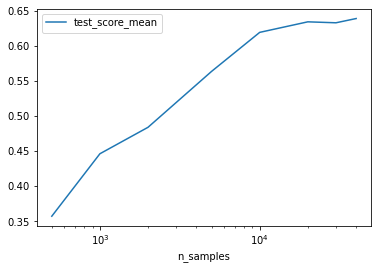

In [ ]:
grps.columns = grps.columns.map('_'.join)
grps.reset_index().plot(x='n_samples', y='test_score_mean', logx=True);